## 数据预处理
本notebook运行于本机（Mac）

### 数据读取与存储
原始数据的目录结构如下：
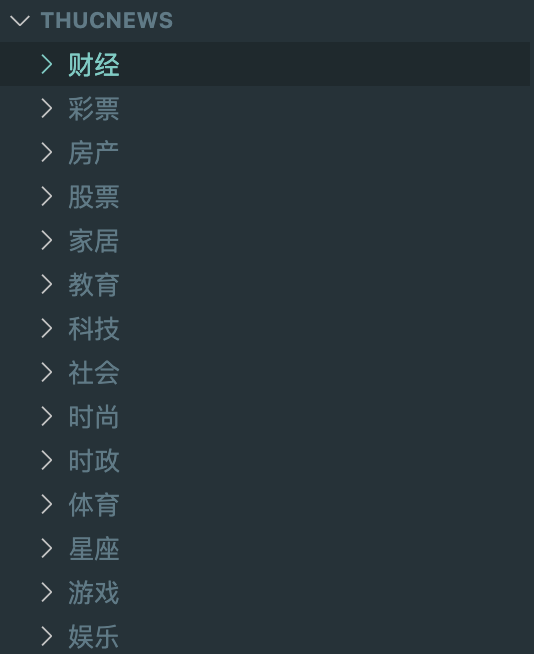
每个文件夹存放着一个类别的新闻数据，每一条数据使用一个单独的txt文件存储

In [15]:
# 定义原始数据所在的文件夹
data_dir = './thunews'

# 定义类别编码
class_dict = {'财经': 1, '彩票': 2, '房产': 3, '股票': 4, '家居': 5, '教育': 6, '科技': 7, '社会': 8, '时尚': 9, '时政': 10, '体育': 11, '星座': 12, '游戏': 13, '娱乐': 14}

# 定义保存数据的列表
data_list = []



In [16]:
import csv
import os
import random
import pandas as pd

考虑到：
1. 训练LLM的开销较大，过多的数据会导致训练时间过长，不利于调整到合适的参数
2. LLM本身具有一定的创造性，微调过程中需要保证不会因为过拟合而丧失这种创造性

首先每类选取300条数据共4200条数据，保存到Thunews_Raw.csv中，每条数据包含标题、正文、类别、标题长度、正文长度五个字段.

In [17]:
# 定义每个类别需要保存的数据条数
num_records_per_class = 300

# 遍历原始文件夹中的每个文件
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        # 如果是文件夹，则读取其中的所有txt文件
        all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.txt')]
        # 随机选择需要保存的数据条数
        num_records = min(num_records_per_class, len(all_files))
        selected_files = random.sample(all_files, num_records)
        # 遍历选择的文件，并读取每个文件的第一行文字数据
        for file_name in selected_files:
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as f:
                first_line = f.readline().strip()
                context = f.read()
            # 将数据和类别编码保存到列表中
            data_list.append([first_line, context,class_dict[folder], folder,len(first_line),len(context)])
            random.shuffle(data_list)

In [18]:
data_list[:5]

[['刘烨儿子取名诺一：生个女儿就叫“千金”',
  '\u3000\u300032岁的刘烨当爸了，给儿子取名“诺一”。昨天，从法国风尘仆仆赶回、直奔《爱出色》官网启动式现场的刘烨，从头到尾都在兴奋：“取名诺一，是因为‘一诺千金’。我跟媳妇早就说好了，生个儿子就叫‘诺一’，生个女儿就叫‘千金’！”\n\u3000\u30009月底，刘烨刚拍完《建党伟业》的戏份，就飞赴法国陪妻子安娜待产，10月10日，他们的混血儿子“诺一”降临人世，“自己有了孩子，才知道当父母有多累。我这个儿子还特别能哭闹，害得我晚上经常睡不好觉。”当上爹的刘烨，更念“父母恩”：“以前我是一周给父母打个电话，有了孩子后，每天都要跟他们联系。我还不断问我妈很幼稚的问题，比如‘我小时候是不是也像小动物似的趴在你们身上一动不动，没父母就活不了？’”本报驻北京记者 梅春艳\n\u3000\u3000《建党伟业》小凤仙\n\u3000\u3000最终花落Angelababy\n\u3000\u3000献礼片《建党伟业》明星众多，不过由谁来扮演同“护国将军”蔡锷有过一段千古之情的小凤仙，一直引人关注。之前被曝已定下由范冰冰出演这一角色。不过昨日，中影对外发布消息称，范冰冰由于档期不合出演不成，这一角色最终花落香港嫩模出身的Angelababy。近日，剧组转站河北迁安，出演蔡锷的刘德华以及Angelababy也相继入组。\n\u3000\u3000据了解，剧组在迁安所拍摄的主要是小凤仙送别蔡锷的戏份，为了找到符合当年情景的老火车以及火车站，剧组可谓费尽心思，一直找到河北迁安。据影片摄影指导赵晓介绍，迁安的火车站机身和车厢保存比较完整，也比较古老，再加上美术、置景与特技，能够最大程度上还原当年小凤仙送别蔡锷的场景。\n\u3000\u3000据剧组介绍，Angelababy最初一直进不了状态，还好刘德华经验很足，主动与Angelababy说戏，悉心引导，好在Angelababy完全放开后，表现不错。记者 冯泽\n\n',
  14,
  '娱乐',
  19,
  742],
 ['乡村乐组合Sugarland遭前队友索赔1400万美元',
  '\u3000\u3000新浪娱乐讯 北京时间11月15日消息，据国外媒体报道，美国乡村乐双人组合Sugarland近日避免了一场与前组合成员之间的财务诉讼庭审，前乐队成员

考虑到：
1. 需要人工对生成结果进行排序，因此验证集不宜过多
2. 需要对比ChatGPT的生成效果，而ChatGPT的API调用需要收费，因此验证集不宜过多
3. Few-shot的方法中数据输入收到模型的字符限制（2048token），且对数据的输入顺序较为敏感，更适合固定训练集与测试集

因此，设置验证集与测试集为200条，训练集2400条。

### 数据清洗

In [19]:
with open('data/THUNews_Raw.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['title', 'context', 'label', 'class', 'title_len', 'context_len'])
    writer.writerows(data_list)

In [20]:
import matplotlib.pyplot as plt

def describe_data(df):
    print('数据条数：', len(df))
    print('--------数据示例--------')
    print(df.head())
    print('--------数据类别信息--------')
    print('类别分布：')
    print(df['class'].value_counts())
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    # 绘制类别分布图
    plt.figure(figsize=(10, 6))
    plt.bar(df['class'].value_counts().index, df['class'].value_counts().values)
    plt.show()
    print('--------数据长度信息--------')
    print('标题最大、平均、最小长度：', df['title_len'].max(), df['title_len'].mean(), df['title_len'].min())
    print('正文最大、平均、最小长度：', df['context_len'].max(), df['context_len'].mean(), df['context_len'].min())
    # 绘制标题长度与正文长度的散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(df['title_len'], df['context_len'])
    
    

数据条数： 4200
--------数据示例--------
                         title  \
0          刘烨儿子取名诺一：生个女儿就叫“千金”   
1  乡村乐组合Sugarland遭前队友索赔1400万美元   
2     彩民周刊10139期双色球：一区2路号已亟待回补   
3            女子锤杀出轨丈夫割下其生殖器(图)   
4            北大考研记：打开双手世界就在你手中   

                                             context  label class  title_len  \
0  　　32岁的刘烨当爸了，给儿子取名“诺一”。昨天，从法国风尘仆仆赶回、直奔《爱出色》官网启动...     14    娱乐         19   
1  　　新浪娱乐讯 北京时间11月15日消息，据国外媒体报道，美国乡村乐双人组合Sugarlan...     14    娱乐         27   
2  　　综述下期遗漏值\n　　一、遗漏1期号码07、09、10、13、19、33。\n　　上述号...      2    彩票         24   
3  　　本报讯 昨日，漳州龙文区法院对“女子锤死丈夫并割下其生殖器”一案进行一审判决，被告人王某...      8    社会         17   
4  　　天空映射着未名湖的秀美，漫步在湖边小路，此情此景，刺激我敏感的思绪奔越进数年前，回想与北...      6    教育         17   

   context_len  
0          742  
1          840  
2          982  
3          859  
4         1216  
--------数据类别信息--------
类别分布：
娱乐    300
彩票    300
社会    300
教育    300
体育    300
房产    300
家居    300
科技    300
财经    300
时政    300
股票    300
游戏    300
星座    300
时尚    300
Name: class

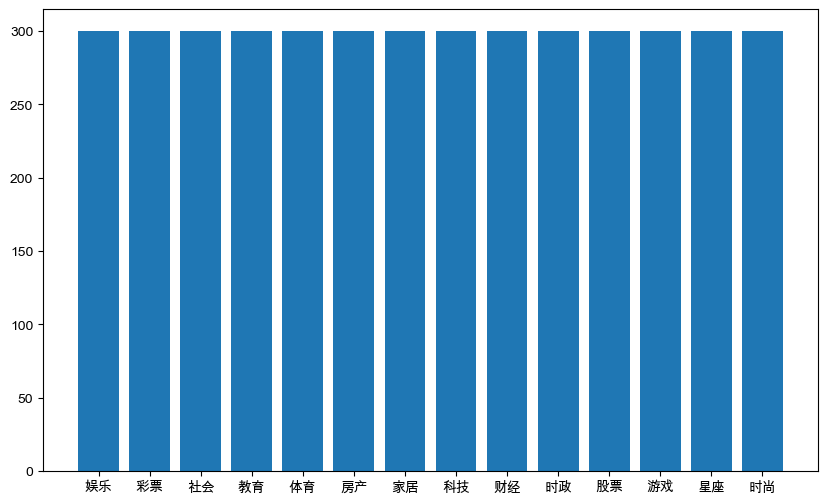

--------数据长度信息--------
标题最大、平均、最小长度： 31 19.159761904761904 4
正文最大、平均、最小长度： 11780 906.0864285714285 6


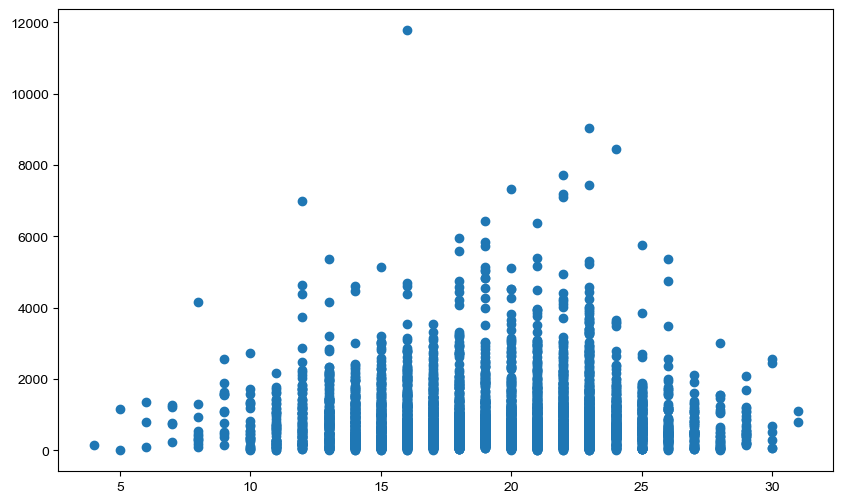

In [21]:
describe_data(pd.read_csv('data/THUNews_Raw.csv'))

In [22]:

# 将正文长度小于15或大于6000，标题长度小于5或大于30的数据剔除
df = pd.read_csv('data/THUNews_Raw.csv')
df = df[(df['context_len'] >= 15) & (df['context_len'] <= 1500) & (df['title_len'] >= 5) & (df['title_len'] <= 30)]


数据条数： 3511
--------数据示例--------
                         title  \
0          刘烨儿子取名诺一：生个女儿就叫“千金”   
1  乡村乐组合Sugarland遭前队友索赔1400万美元   
2     彩民周刊10139期双色球：一区2路号已亟待回补   
3            女子锤杀出轨丈夫割下其生殖器(图)   
4            北大考研记：打开双手世界就在你手中   

                                             context  label class  title_len  \
0  　　32岁的刘烨当爸了，给儿子取名“诺一”。昨天，从法国风尘仆仆赶回、直奔《爱出色》官网启动...     14    娱乐         19   
1  　　新浪娱乐讯 北京时间11月15日消息，据国外媒体报道，美国乡村乐双人组合Sugarlan...     14    娱乐         27   
2  　　综述下期遗漏值\n　　一、遗漏1期号码07、09、10、13、19、33。\n　　上述号...      2    彩票         24   
3  　　本报讯 昨日，漳州龙文区法院对“女子锤死丈夫并割下其生殖器”一案进行一审判决，被告人王某...      8    社会         17   
4  　　天空映射着未名湖的秀美，漫步在湖边小路，此情此景，刺激我敏感的思绪奔越进数年前，回想与北...      6    教育         17   

   context_len  
0          742  
1          840  
2          982  
3          859  
4         1216  
--------数据类别信息--------
类别分布：
时尚    283
时政    280
娱乐    268
科技    265
股票    264
游戏    262
家居    255
房产    253
体育    249
星座    248
社会    224
教育    222
财经    220
彩票    218
Name: class

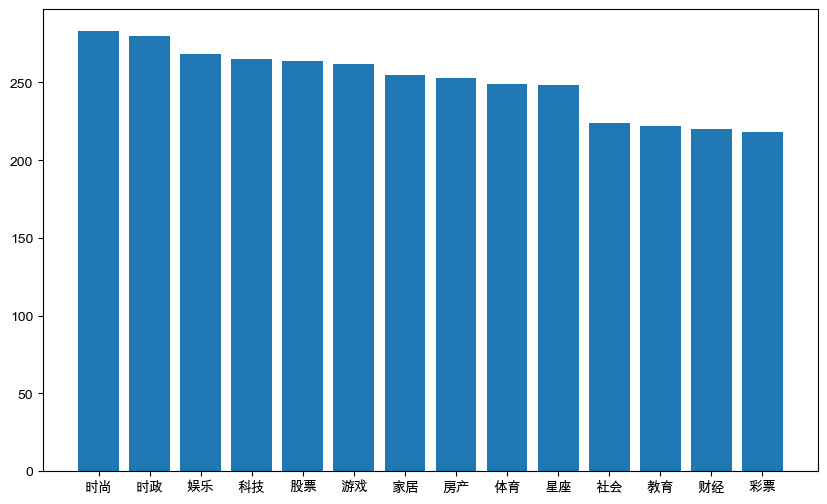

--------数据长度信息--------
标题最大、平均、最小长度： 30 19.12959270863002 5
正文最大、平均、最小长度： 1500 606.2423810880091 16


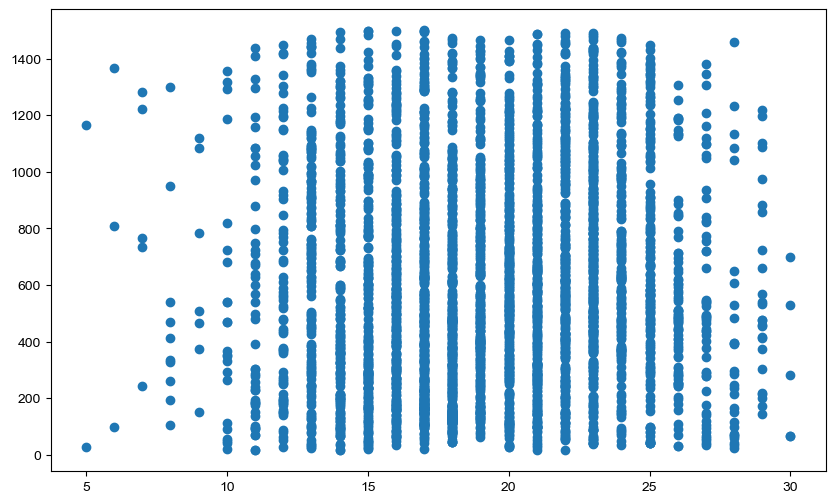

In [23]:
describe_data(df)

### 数据集划分

In [24]:
# 定义每个类别需要保存的数据条数
num_test_records, num_val_records, num_train_records = (200, 200, 2400)
test_df = df[:num_test_records]
val_df = df[num_test_records:num_test_records + num_val_records]
train_df = df[num_test_records + num_val_records:num_test_records + num_val_records + num_train_records]


In [25]:
# 保存训练集、验证集和测试集
test_df.to_csv('data/test_data.csv', index=False)
val_df.to_csv('data/val_data.csv', index=False)
train_df.to_csv('data/train_data.csv', index=False)

### 数据描述性统计

数据条数： 200
--------数据示例--------
                         title  \
0          刘烨儿子取名诺一：生个女儿就叫“千金”   
1  乡村乐组合Sugarland遭前队友索赔1400万美元   
2     彩民周刊10139期双色球：一区2路号已亟待回补   
3            女子锤杀出轨丈夫割下其生殖器(图)   
4            北大考研记：打开双手世界就在你手中   

                                             context  label class  title_len  \
0  　　32岁的刘烨当爸了，给儿子取名“诺一”。昨天，从法国风尘仆仆赶回、直奔《爱出色》官网启动...     14    娱乐         19   
1  　　新浪娱乐讯 北京时间11月15日消息，据国外媒体报道，美国乡村乐双人组合Sugarlan...     14    娱乐         27   
2  　　综述下期遗漏值\n　　一、遗漏1期号码07、09、10、13、19、33。\n　　上述号...      2    彩票         24   
3  　　本报讯 昨日，漳州龙文区法院对“女子锤死丈夫并割下其生殖器”一案进行一审判决，被告人王某...      8    社会         17   
4  　　天空映射着未名湖的秀美，漫步在湖边小路，此情此景，刺激我敏感的思绪奔越进数年前，回想与北...      6    教育         17   

   context_len  
0          742  
1          840  
2          982  
3          859  
4         1216  
--------数据类别信息--------
类别分布：
彩票    21
社会    20
科技    18
娱乐    17
房产    17
游戏    17
星座    14
教育    13
股票    13
体育    12
时尚    11
财经    10
家居     9
时政     8
Name: class, dtype: int64


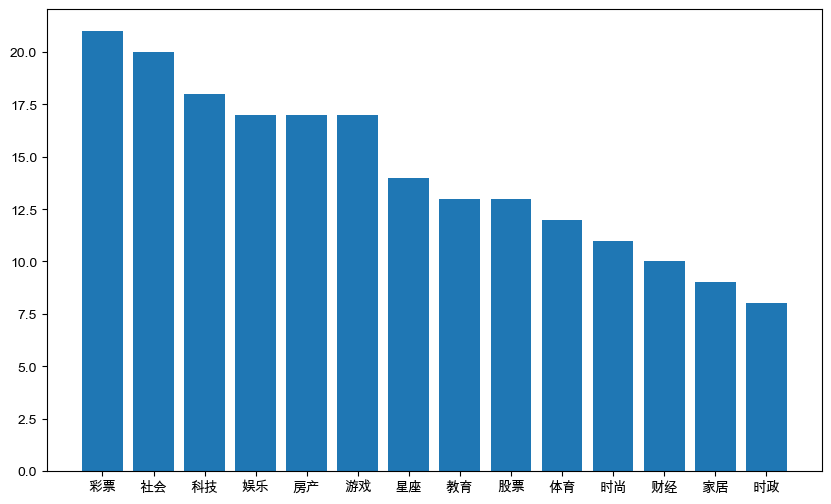

--------数据长度信息--------
标题最大、平均、最小长度： 29 19.33 7
正文最大、平均、最小长度： 1401 654.55 32


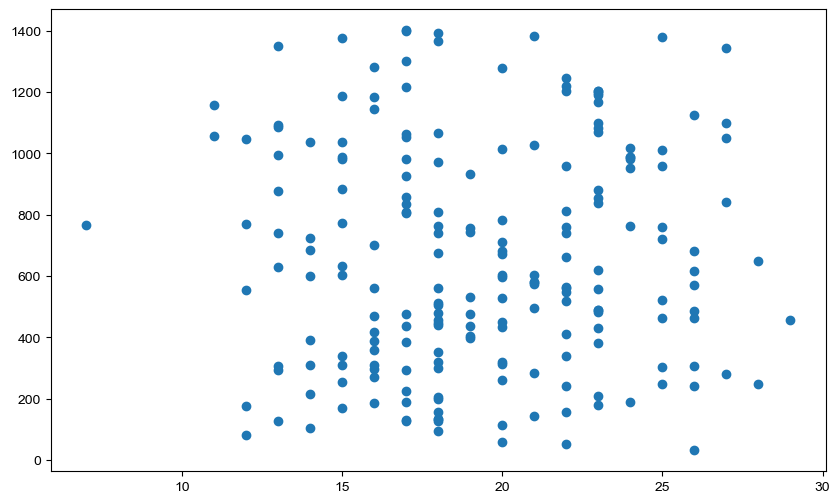

In [26]:
describe_data(test_df)

数据条数： 2400
--------数据示例--------
                           title  \
473        组图：刘芳菲低调亮相 与名嘴撒贝宁献身公益   
474                马骏：人民币国际化利好香港   
475            西部水泥超购136倍 冻资190亿   
476  胜负彩09084期彩果凯尔特人告负 任九销量1476万   
477              诺基亚手机游戏服务登陆中国市场   

                                               context  label class  \
473  　　新浪娱乐讯 7月13日，央视3大名嘴撒贝宁、刘芳菲、朱迅共同参加了由某一美容机构主办的“...     14    娱乐   
474  　　□本报记者 黄继汇 北京报道\n　　德意志银行大中华区首席经济学家马骏博士日前指出，未来...      4    股票   
475  　　新浪财经讯 8月18日消息，西部水泥(2233)将以招股价上限1.69元定价，集资13....      4    股票   
476  　　胜负彩09084期14场游戏全国总销量：13817364元，任选九场总销量：147611...      2    彩票   
477  　　\n　　(诺基亚N96)\n　　红网12月12日讯（潇湘晨报记者 李伟）国内游戏玩家期待...     13    游戏   

     title_len  context_len  
473         21          139  
474         13         1266  
475         17          425  
476         27           52  
477         15         1028  
--------数据类别信息--------
类别分布：
时尚    207
时政    199
家居    185
房产    183
体育    180
游戏    179
科技    179
娱乐    178
股票    175
星座    166
教育    151
社会   

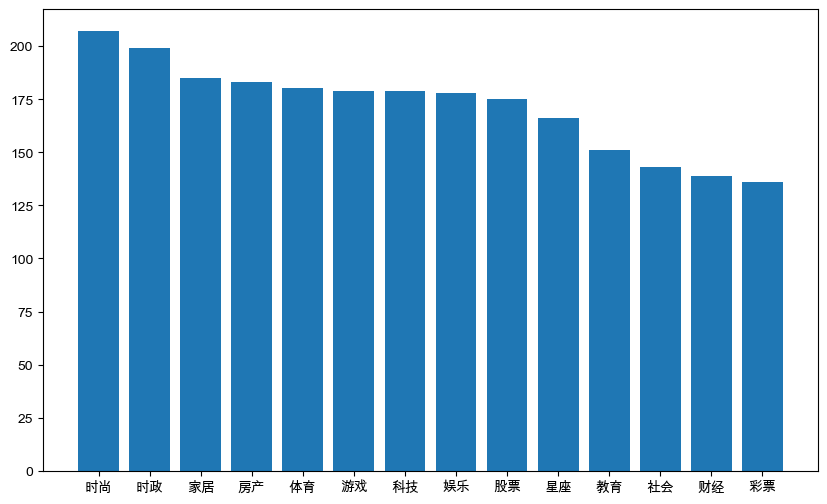

--------数据长度信息--------
标题最大、平均、最小长度： 30 19.102083333333333 6
正文最大、平均、最小长度： 1499 598.59375 16


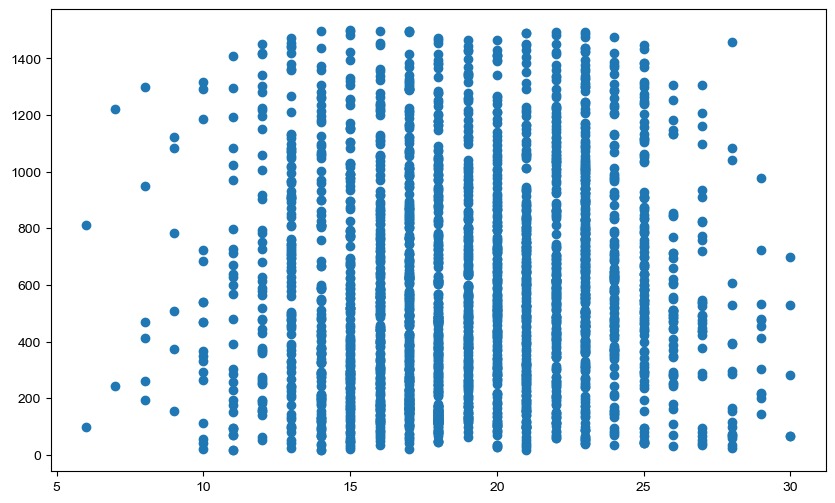

In [27]:
describe_data(train_df)

数据条数： 200
--------数据示例--------
                             title  \
239      东二环精装小户13000元起 付全款96折(组图)   
240       Adobe：IE10不支持Flash插件影响不大   
241  詹天佑09149期福彩3D分析：胆码7 合值范围10-19   
242          低调之中尽显光芒 徕卡X1送手柄15980   
244        欧洲杯预选赛积分榜 德意逼近出线 法国优势缩小   

                                               context  label class  \
239  　　东二环精装MINI空间——FREE自由季，主力户型56平米一居，定于5月16日盛大开盘，...      3    房产   
240  　　新浪科技讯 北京时间9月16日早间消息，微软已表示，Windows 8的“Metro”风...      7    科技   
241  　　一、本人通过钟摆撞击来分析，上期开出奖号831最后的落脚点立于1数字，本期钟摆力会有所改...      2    彩票   
242  　　【5月24日太平洋电脑网浙江站】如果说当年的徕卡品牌代表着一个大众品牌，代表着摄影工业的...      7    科技   
244  　　北京时间6月4日凌晨，2012欧洲杯预选赛进行第6轮比赛，结果德国和意大利战胜对手提前出...      2    彩票   

     title_len  context_len  
239         25          173  
240         24          557  
241         29          418  
242         21          241  
244         23          285  
--------数据类别信息--------
类别分布：
社会    21
科技    19
股票    19
游戏    17
家居    16
星座    14
教育    14
房产    13
娱乐    13
彩票    11
时政    11
财经   

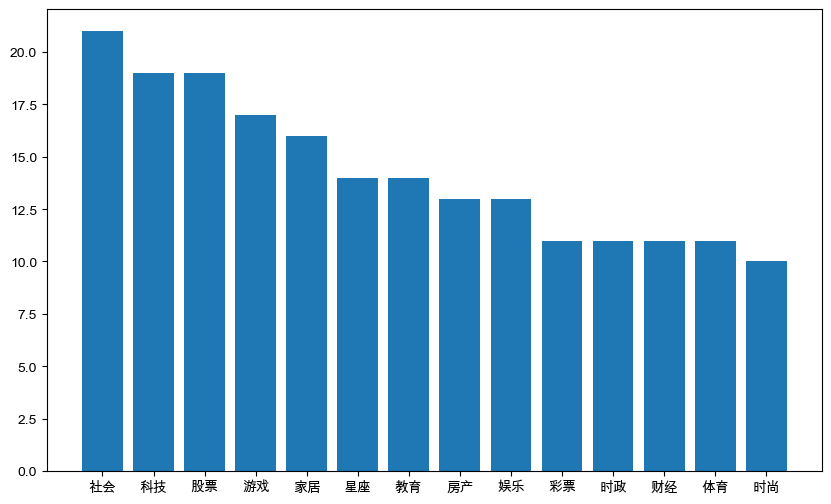

--------数据长度信息--------
标题最大、平均、最小长度： 29 18.57 6
正文最大、平均、最小长度： 1463 591.795 29


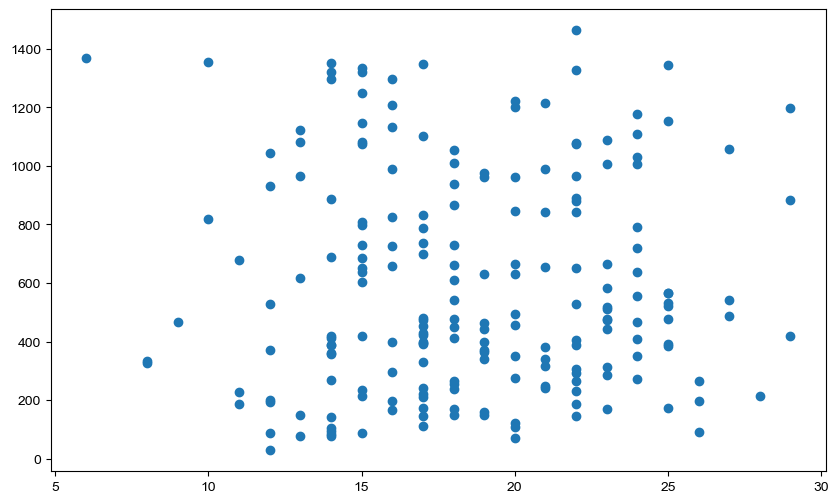

In [28]:
describe_data(val_df)